In [1]:
import numpy as np
from tensorforce.agents import PPOAgent
import numpy as np
import random
from sklearn.datasets import make_classification, make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import cv2
from keras.models import model_from_json
from tensorforce.agents import Agent
import json
import keras

n_features = 3
n_clusters = 5
n_samples = 5
n_vocab = 3
max_len = 2

img_dim = 10
img_features_len = 32
n_batches = 16
n_epochs = 10000000

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

In [2]:
csvname = "features-{}_clusters-{}".format(n_features, n_clusters)
try:
    df = pd.read_csv("csvs/"+csvname)
    X1 = df.iloc[:, 1:n_features+1].values
    Y1 = df['y'].values
    print("Successfully read data from csv")
except:
    print("csv not found, creating new csv")
    X1, Y1 = make_blobs(n_samples=10000, n_features=n_features, centers=n_clusters)
    scaler = MinMaxScaler()
    X1 = scaler.fit_transform(X1)
    df = pd.DataFrame(X1)
    df['y'] = Y1
    df.to_csv("csvs/"+csvname)
    
# scaler = MinMaxScaler()
# X1 = scaler.fit_transform(df[['x1', 'x2','x3' ]].values)

Successfully read data from csv


In [30]:
with open("mlp3_innerlstm.json") as fp:
    network_deep_lstm = json.load(fp)

with open("mlp3_network.json") as fp:
    network_deep = json.load(fp)
    
with open("ppo.json") as fp:
    agent_spec = json.load(fp)

with open("ppo-big.json") as fp:
    agent_spec_big = json.load(fp)

with open("ppo-big-bal.json") as fp:
    agent_spec_big_bal = json.load(fp)
    
Speaker = Agent.from_spec(
    spec=agent_spec_big,
    kwargs=dict(
        states=dict(type='float', shape=(n_features+100,)),
        actions=dict(type='int', num_actions=img_dim, shape=(4,)),
        network=network_deep,
    )
)

Listener = Agent.from_spec(
    spec=agent_spec_big,
    kwargs=dict(
        states=dict(type='float', shape=(n_samples*n_features + img_features_len,)),
        actions=dict(type='int', num_actions=n_samples),
        network=network_deep,
    )
)
Speaker.reset()
Listener.reset()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [31]:
# Speaker.act([0.2, 0.2, 0.3])
# Speaker.act([0.2, 0.2, 0.3])
# Speaker.model.observe(reward=[1, 0], terminal=[True, True])

a=(img_features_len+n_features*n_samples)*96+96*128+128*96+96*n_samples
b = (n_features+img_features_len)*96+96*128+128*96+96*img_dim*4
a, b

(29568, 31776)

In [32]:
# json_file = open('mnist_feature_model.json', 'r')
json_file = open('feature_model.json', 'r')

intermediate_layer_model = json_file.read()
json_file.close()
intermediate_layer_model = model_from_json(intermediate_layer_model)
# load weights into new model
# intermediate_layer_model.load_weights("mnist_feature_model.h5")
intermediate_layer_model.load_weights("feature_model.h5")

intermediate_layer_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

def get_features(img_batch):
    batch_size = len(img_batch)
    img_batch = np.array(img_batch)
#     assert img_batch.shape == (batch_size, 30, 30)
#     assert img_batch.shape == (batch_size, 10, 10)
#     img_batch = img_batch.reshape(batch_size, 30, 30, 1)
    img_batch = img_batch.reshape(batch_size, 105, 105, 1)
#     img_batch = img_batch.reshape(batch_size, 100)
#     layer_name = 'dense_5'
#     intermediate_layer_model = Model(inputs=model.input,
#                                      outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(img_batch)
    return intermediate_output
#     return img_batch

def message_to_image(strokes):
#         img = np.zeros((28,28), np.uint8)
    img = np.zeros((105,105), np.uint8)
    for message in strokes:
        
        sx, sy, ex, ey = message
        sx = 10*sx
        sy = 10*sy
        ex = 10*ex
        ey = 10*ey
    #     s, e = message
    #     sx = s//10
    #     sy = s%10

    #     ex = e//10
    #     ey = e%10
        cv2.line(img,(sx, sy),(ex, ey),(255,0,0),5)
    img = img/255
    return img

def message_to_image_sm(strokes):
#         img = np.zeros((28,28), np.uint8)
    img = np.zeros((10,10), np.uint8)
    for message in strokes:
        
        sx, sy, ex, ey = message
        sx = sx
        sy = sy
        ex = ex
        ey = ey
    #     s, e = message
    #     sx = s//10
    #     sy = s%10

    #     ex = e//10
    #     ey = e%10
        cv2.line(img,(sx, sy),(ex, ey),(255,0,0),2)
    img = img/255
    return img

class Game(object):
    def __init__(self, f, c, s, v, debug=False):
        self.f = f
        self.c = c
        self.s = s
        self.v = v
        self.target = None
        self.states = []
        self.debug=debug
        global X1, Y1
        self.reset()
        
    def getData(self):
        return X1, Y1
    
    def reset(self):
        global X1, Y1
        self.nos = np.random.choice(range(self.c), self.s, replace=False).tolist()
        self.states = [X1[Y1==i][np.random.choice(X1[Y1==i].shape[0], 1)][0] for i in self.nos]
        self.target = 0
    
    def speaker_input(self, img):
        inp = list(self.states[0])
        inp.extend(list(img.flatten()))
        return inp
              
    def listener_input(self, features):
        shuffled_index, shuffled_states = zip(*sorted(zip(range(self.s), self.states), key=lambda _: random.random()))
        self.target = list(shuffled_index).index(0)
        lst = np.array(shuffled_states).flatten().tolist()
        lst.extend(features)
        if self.debug:
            print(lst)
        return lst
        
    def reward(self, out):
        assert self.target is not None
        if out == self.target:
            return 1
        else:
            return 0    

In [33]:
# %matplotlib inline
# game = Game(n_features, n_clusters, n_samples, n_vocab)
# strokes = []
# strokes.append(Speaker.act(states= game.speaker_input(np.zeros((10,10), np.uint8))) ) # (scalar between 0 and 4)
# img = message_to_image_sm(strokes)
# # print(img)
# # feat = get_features([img])[0]
# strokes.append(Speaker.act(states= game.speaker_input(img.flatten())) )
# print (strokes)
# img = message_to_image(strokes)
# plt.imshow(img)
# # print(game.listener_input(img))
# # out = Listener.act(states = game.listener_input(img))
# # print(out)

In [34]:
game_pool = []
for i in range(n_batches):
    game_pool.append(Game(n_features, n_clusters, n_samples, n_vocab))

<IPython.core.display.Javascript object>


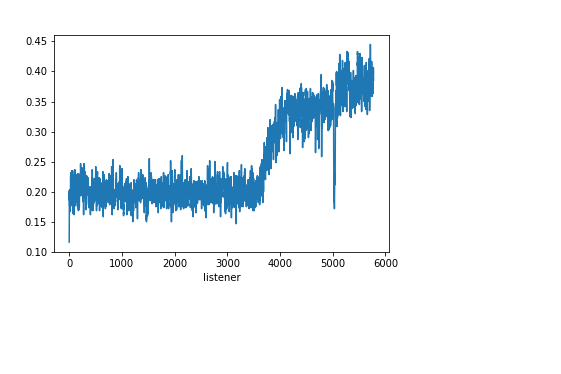

 message:  [3 2 7 7]
 output:  0
 epoch no:  0  avg reward 0.0625
 message:  [5 1 7 7]
 output:  0
 epoch no:  6  avg reward 0.11607142857142858
 message:  [9 4 4 5]
 output:  0
 epoch no:  12  avg reward 0.1778846153846154
 message:  [5 0 5 4]
 output:  0
 epoch no:  18  avg reward 0.19078947368421054
 message:  [0 3 6 5]
 output:  0
 epoch no:  24  avg reward 0.2025
 message:  [6 3 7 8]
 output:  1
 epoch no:  30  avg reward 0.1875
 message:  [1 3 7 2]
 output:  1
 epoch no:  36  avg reward 0.1858108108108108
 message:  [5 1 4 2]
 output:  1
 epoch no:  42  avg reward 0.2
 message:  [1 3 1 3]
 output:  3
 epoch no:  48  avg reward 0.17833333333333334
 message:  [7 1 2 0]
 output:  0
 epoch no:  54  avg reward 0.17666666666666667
 message:  [8 1 8 4]
 output:  4
 epoch no:  60  avg reward 0.19166666666666668
 message:  [2 0 9 4]
 output:  3
 epoch no:  66  avg reward 0.19833333333333333
 message:  [7 9 3 5]
 output:  0
 epoch no:  72  avg reward 0.2
 message:  [9 2 2 1]
 output:  4
 e

 message:  [8 1 3 2]
 output:  2
 epoch no:  654  avg reward 0.22166666666666668
 message:  [5 1 4 8]
 output:  2
 epoch no:  660  avg reward 0.2
 message:  [8 2 1 5]
 output:  4
 epoch no:  666  avg reward 0.19666666666666666
 message:  [6 1 3 5]
 output:  2
 epoch no:  672  avg reward 0.18666666666666668
 message:  [8 7 8 0]
 output:  3
 epoch no:  678  avg reward 0.19166666666666668
 message:  [7 0 1 2]
 output:  4
 epoch no:  684  avg reward 0.185
 message:  [8 0 3 2]
 output:  1
 epoch no:  690  avg reward 0.18666666666666668
 message:  [0 5 4 5]
 output:  1
 epoch no:  696  avg reward 0.18833333333333332
 message:  [0 8 3 2]
 output:  1
 epoch no:  702  avg reward 0.18
 message:  [6 8 6 5]
 output:  1
 epoch no:  708  avg reward 0.185
 message:  [3 5 3 0]
 output:  4
 epoch no:  714  avg reward 0.17666666666666667
 message:  [6 6 3 7]
 output:  2
 epoch no:  720  avg reward 0.185
 message:  [0 0 3 2]
 output:  3
 epoch no:  726  avg reward 0.19
 message:  [6 4 1 5]
 output:  1
 e

 message:  [5 8 1 8]
 output:  4
 epoch no:  1296  avg reward 0.24
 message:  [7 3 3 1]
 output:  3
 epoch no:  1302  avg reward 0.24666666666666667
 message:  [3 1 3 2]
 output:  1
 epoch no:  1308  avg reward 0.23666666666666666
 message:  [3 1 3 2]
 output:  3
 epoch no:  1314  avg reward 0.23
 message:  [3 8 5 8]
 output:  1
 epoch no:  1320  avg reward 0.22833333333333333
 message:  [7 6 5 8]
 output:  4
 epoch no:  1326  avg reward 0.21833333333333332
 message:  [7 6 7 2]
 output:  3
 epoch no:  1332  avg reward 0.21166666666666667
 message:  [6 7 7 8]
 output:  3
 epoch no:  1338  avg reward 0.19833333333333333
 message:  [6 7 5 0]
 output:  3
 epoch no:  1344  avg reward 0.19333333333333333
 message:  [6 7 5 3]
 output:  3
 epoch no:  1350  avg reward 0.19666666666666666
 message:  [6 6 5 8]
 output:  3
 epoch no:  1356  avg reward 0.2
 message:  [3 2 3 8]
 output:  3
 epoch no:  1362  avg reward 0.215
 message:  [5 7 3 0]
 output:  3
 epoch no:  1368  avg reward 0.216666666666

 message:  [0 3 3 2]
 output:  0
 epoch no:  1938  avg reward 0.19833333333333333
 message:  [6 8 5 2]
 output:  3
 epoch no:  1944  avg reward 0.20833333333333334
 message:  [6 8 5 3]
 output:  2
 epoch no:  1950  avg reward 0.2
 message:  [6 1 8 4]
 output:  3
 epoch no:  1956  avg reward 0.20666666666666667
 message:  [6 8 4 9]
 output:  2
 epoch no:  1962  avg reward 0.2
 message:  [0 8 4 3]
 output:  4
 epoch no:  1968  avg reward 0.21
 message:  [6 8 4 5]
 output:  4
 epoch no:  1974  avg reward 0.20333333333333334
 message:  [6 6 5 5]
 output:  3
 epoch no:  1980  avg reward 0.21666666666666667
 message:  [6 6 8 5]
 output:  4
 epoch no:  1986  avg reward 0.22666666666666666
 message:  [6 8 5 5]
 output:  4
 epoch no:  1992  avg reward 0.21833333333333332
 message:  [6 8 5 8]
 output:  3
 epoch no:  1998  avg reward 0.22
 message:  [7 1 3 5]
 output:  4
 epoch no:  2004  avg reward 0.22166666666666668
 message:  [5 1 1 3]
 output:  3
 epoch no:  2010  avg reward 0.22
 message:  

 message:  [7 5 4 5]
 output:  4
 epoch no:  2586  avg reward 0.21166666666666667
 message:  [2 5 5 5]
 output:  4
 epoch no:  2592  avg reward 0.2
 message:  [7 5 4 5]
 output:  4
 epoch no:  2598  avg reward 0.20333333333333334
 message:  [7 5 4 5]
 output:  4
 epoch no:  2604  avg reward 0.20666666666666667
 message:  [0 2 8 5]
 output:  4
 epoch no:  2610  avg reward 0.21333333333333335
 message:  [6 5 4 5]
 output:  4
 epoch no:  2616  avg reward 0.20833333333333334
 message:  [7 5 4 5]
 output:  4
 epoch no:  2622  avg reward 0.205
 message:  [6 8 4 7]
 output:  4
 epoch no:  2628  avg reward 0.22333333333333333
 message:  [2 7 5 5]
 output:  4
 epoch no:  2634  avg reward 0.23666666666666666
 message:  [2 0 8 3]
 output:  4
 epoch no:  2640  avg reward 0.22333333333333333
 message:  [2 5 4 5]
 output:  4
 epoch no:  2646  avg reward 0.21166666666666667
 message:  [9 8 4 4]
 output:  4
 epoch no:  2652  avg reward 0.22333333333333333
 message:  [2 8 4 5]
 output:  4
 epoch no:  2

 message:  [0 1 3 5]
 output:  3
 epoch no:  3222  avg reward 0.23333333333333334
 message:  [5 0 3 5]
 output:  4
 epoch no:  3228  avg reward 0.22333333333333333
 message:  [2 7 3 5]
 output:  1
 epoch no:  3234  avg reward 0.215
 message:  [2 0 3 5]
 output:  4
 epoch no:  3240  avg reward 0.215
 message:  [5 0 0 5]
 output:  3
 epoch no:  3246  avg reward 0.19333333333333333
 message:  [0 0 3 5]
 output:  1
 epoch no:  3252  avg reward 0.19166666666666668
 message:  [9 7 3 5]
 output:  3
 epoch no:  3258  avg reward 0.19666666666666666
 message:  [1 0 3 1]
 output:  4
 epoch no:  3264  avg reward 0.19333333333333333
 message:  [5 0 3 5]
 output:  4
 epoch no:  3270  avg reward 0.20833333333333334
 message:  [5 0 3 5]
 output:  4
 epoch no:  3276  avg reward 0.22166666666666668
 message:  [5 0 3 5]
 output:  4
 epoch no:  3282  avg reward 0.21166666666666667
 message:  [0 7 3 5]
 output:  1
 epoch no:  3288  avg reward 0.22
 message:  [0 1 3 5]
 output:  4
 epoch no:  3294  avg rewa

 message:  [0 7 3 7]
 output:  3
 epoch no:  3858  avg reward 0.20333333333333334
 message:  [0 8 4 7]
 output:  3
 epoch no:  3864  avg reward 0.19833333333333333
 message:  [6 7 3 5]
 output:  3
 epoch no:  3870  avg reward 0.18833333333333332
 message:  [2 8 4 7]
 output:  1
 epoch no:  3876  avg reward 0.17833333333333334
 message:  [0 8 4 7]
 output:  3
 epoch no:  3882  avg reward 0.15833333333333333
 message:  [2 3 4 7]
 output:  1
 epoch no:  3888  avg reward 0.17333333333333334
 message:  [6 2 4 7]
 output:  3
 epoch no:  3894  avg reward 0.18
 message:  [6 7 4 7]
 output:  3
 epoch no:  3900  avg reward 0.18
 message:  [0 3 3 7]
 output:  1
 epoch no:  3906  avg reward 0.20166666666666666
 message:  [5 4 4 3]
 output:  3
 epoch no:  3912  avg reward 0.20166666666666666
 message:  [6 7 4 5]
 output:  1
 epoch no:  3918  avg reward 0.22333333333333333
 message:  [0 3 3 1]
 output:  3
 epoch no:  3924  avg reward 0.22
 message:  [0 7 3 7]
 output:  1
 epoch no:  3930  avg reward

 message:  [7 8 4 1]
 output:  3
 epoch no:  4500  avg reward 0.19333333333333333
 message:  [6 8 4 5]
 output:  4
 epoch no:  4506  avg reward 0.20666666666666667
 message:  [7 8 7 1]
 output:  4
 epoch no:  4512  avg reward 0.20166666666666666
 message:  [7 3 3 1]
 output:  4
 epoch no:  4518  avg reward 0.225
 message:  [7 8 4 1]
 output:  4
 epoch no:  4524  avg reward 0.21333333333333335
 message:  [7 3 3 1]
 output:  4
 epoch no:  4530  avg reward 0.22833333333333333
 message:  [0 3 3 1]
 output:  3
 epoch no:  4536  avg reward 0.22333333333333333
 message:  [0 3 3 1]
 output:  4
 epoch no:  4542  avg reward 0.23
 message:  [0 3 3 1]
 output:  3
 epoch no:  4548  avg reward 0.22166666666666668
 message:  [0 3 3 1]
 output:  4
 epoch no:  4554  avg reward 0.22166666666666668
 message:  [5 8 7 2]
 output:  4
 epoch no:  4560  avg reward 0.21333333333333335
 message:  [7 3 7 1]
 output:  3
 epoch no:  4566  avg reward 0.21833333333333332
 message:  [0 3 3 1]
 output:  4
 epoch no:  

 message:  [5 8 7 7]
 output:  4
 epoch no:  5142  avg reward 0.19166666666666668
 message:  [0 3 3 1]
 output:  4
 epoch no:  5148  avg reward 0.18666666666666668
 message:  [6 8 4 5]
 output:  3
 epoch no:  5154  avg reward 0.2
 message:  [6 8 4 5]
 output:  3
 epoch no:  5160  avg reward 0.20333333333333334
 message:  [6 8 4 5]
 output:  3
 epoch no:  5166  avg reward 0.20166666666666666
 message:  [0 3 9 1]
 output:  3
 epoch no:  5172  avg reward 0.20333333333333334
 message:  [5 8 7 7]
 output:  3
 epoch no:  5178  avg reward 0.19666666666666666
 message:  [5 8 7 7]
 output:  3
 epoch no:  5184  avg reward 0.2
 message:  [9 8 7 7]
 output:  3
 epoch no:  5190  avg reward 0.19
 message:  [5 8 4 7]
 output:  3
 epoch no:  5196  avg reward 0.195
 message:  [6 8 4 5]
 output:  4
 epoch no:  5202  avg reward 0.18333333333333332
 message:  [5 8 7 7]
 output:  4
 epoch no:  5208  avg reward 0.19833333333333333
 message:  [5 4 9 5]
 output:  3
 epoch no:  5214  avg reward 0.1883333333333

 message:  [5 3 7 7]
 output:  4
 epoch no:  5778  avg reward 0.22
 message:  [8 3 3 1]
 output:  3
 epoch no:  5784  avg reward 0.21
 message:  [6 7 4 7]
 output:  3
 epoch no:  5790  avg reward 0.20333333333333334
 message:  [6 7 4 7]
 output:  3
 epoch no:  5796  avg reward 0.205
 message:  [6 9 4 5]
 output:  3
 epoch no:  5802  avg reward 0.195
 message:  [0 3 7 7]
 output:  3
 epoch no:  5808  avg reward 0.19666666666666666
 message:  [5 3 7 7]
 output:  3
 epoch no:  5814  avg reward 0.21166666666666667
 message:  [0 3 3 7]
 output:  3
 epoch no:  5820  avg reward 0.21166666666666667
 message:  [5 3 7 7]
 output:  3
 epoch no:  5826  avg reward 0.21166666666666667
 message:  [0 3 7 7]
 output:  3
 epoch no:  5832  avg reward 0.21166666666666667
 message:  [2 3 3 7]
 output:  3
 epoch no:  5838  avg reward 0.21166666666666667
 message:  [6 3 4 7]
 output:  3
 epoch no:  5844  avg reward 0.195
 message:  [5 3 7 7]
 output:  3
 epoch no:  5850  avg reward 0.18833333333333332
 messa

 message:  [0 3 9 7]
 output:  4
 epoch no:  6432  avg reward 0.21
 message:  [0 3 9 7]
 output:  3
 epoch no:  6438  avg reward 0.205
 message:  [0 3 9 7]
 output:  3
 epoch no:  6444  avg reward 0.19833333333333333
 message:  [0 3 3 1]
 output:  3
 epoch no:  6450  avg reward 0.20833333333333334
 message:  [0 7 9 5]
 output:  3
 epoch no:  6456  avg reward 0.21666666666666667
 message:  [0 3 3 1]
 output:  3
 epoch no:  6462  avg reward 0.19833333333333333
 message:  [0 3 9 7]
 output:  1
 epoch no:  6468  avg reward 0.195
 message:  [0 3 3 1]
 output:  2
 epoch no:  6474  avg reward 0.20166666666666666
 message:  [8 7 9 1]
 output:  3
 epoch no:  6480  avg reward 0.20166666666666666
 message:  [0 3 9 5]
 output:  3
 epoch no:  6486  avg reward 0.205
 message:  [0 3 9 5]
 output:  3
 epoch no:  6492  avg reward 0.20833333333333334
 message:  [0 3 9 5]
 output:  3
 epoch no:  6498  avg reward 0.21666666666666667
 message:  [2 5 9 7]
 output:  3
 epoch no:  6504  avg reward 0.208333333

 message:  [3 8 2 4]
 output:  0
 epoch no:  7062  avg reward 0.215
 message:  [3 5 6 1]
 output:  3
 epoch no:  7068  avg reward 0.205
 message:  [6 4 4 4]
 output:  0
 epoch no:  7074  avg reward 0.20666666666666667
 message:  [2 5 3 1]
 output:  0
 epoch no:  7080  avg reward 0.18833333333333332
 message:  [0 3 3 1]
 output:  3
 epoch no:  7086  avg reward 0.18166666666666667
 message:  [2 5 3 1]
 output:  0
 epoch no:  7092  avg reward 0.17
 message:  [5 8 5 7]
 output:  0
 epoch no:  7098  avg reward 0.16
 message:  [0 8 0 1]
 output:  3
 epoch no:  7104  avg reward 0.17833333333333334
 message:  [3 8 9 4]
 output:  0
 epoch no:  7110  avg reward 0.16666666666666666
 message:  [0 3 3 1]
 output:  3
 epoch no:  7116  avg reward 0.185
 message:  [5 8 0 7]
 output:  3
 epoch no:  7122  avg reward 0.195
 message:  [2 3 9 1]
 output:  3
 epoch no:  7128  avg reward 0.19666666666666666
 message:  [2 5 0 1]
 output:  3
 epoch no:  7134  avg reward 0.20166666666666666
 message:  [5 8 9 7]

 message:  [2 5 6 1]
 output:  2
 epoch no:  7704  avg reward 0.18833333333333332
 message:  [6 5 6 4]
 output:  3
 epoch no:  7710  avg reward 0.185
 message:  [6 5 6 7]
 output:  3
 epoch no:  7716  avg reward 0.19
 message:  [2 5 6 1]
 output:  2
 epoch no:  7722  avg reward 0.205
 message:  [5 5 6 4]
 output:  3
 epoch no:  7728  avg reward 0.195
 message:  [5 3 0 7]
 output:  3
 epoch no:  7734  avg reward 0.19666666666666666
 message:  [6 5 0 4]
 output:  3
 epoch no:  7740  avg reward 0.19666666666666666
 message:  [5 3 2 4]
 output:  3
 epoch no:  7746  avg reward 0.195
 message:  [6 5 0 4]
 output:  2
 epoch no:  7752  avg reward 0.18166666666666667
 message:  [0 3 0 7]
 output:  3
 epoch no:  7758  avg reward 0.18333333333333332
 message:  [6 5 0 4]
 output:  3
 epoch no:  7764  avg reward 0.18
 message:  [2 5 0 4]
 output:  3
 epoch no:  7770  avg reward 0.16666666666666666
 message:  [0 5 6 7]
 output:  3
 epoch no:  7776  avg reward 0.155
 message:  [5 8 0 7]
 output:  3
 

 message:  [6 7 0 5]
 output:  3
 epoch no:  8340  avg reward 0.20166666666666666
 message:  [6 5 0 5]
 output:  3
 epoch no:  8346  avg reward 0.2
 message:  [6 7 0 5]
 output:  3
 epoch no:  8352  avg reward 0.21666666666666667
 message:  [3 3 0 7]
 output:  3
 epoch no:  8358  avg reward 0.21833333333333332
 message:  [9 3 0 1]
 output:  3
 epoch no:  8364  avg reward 0.21
 message:  [9 7 0 5]
 output:  3
 epoch no:  8370  avg reward 0.21666666666666667
 message:  [9 3 0 5]
 output:  3
 epoch no:  8376  avg reward 0.22833333333333333
 message:  [2 3 0 1]
 output:  2
 epoch no:  8382  avg reward 0.22166666666666668
 message:  [5 3 0 7]
 output:  3
 epoch no:  8388  avg reward 0.21166666666666667
 message:  [3 3 0 1]
 output:  3
 epoch no:  8394  avg reward 0.20666666666666667
 message:  [3 3 0 7]
 output:  3
 epoch no:  8400  avg reward 0.20833333333333334
 message:  [5 3 0 7]
 output:  3
 epoch no:  8406  avg reward 0.20333333333333334
 message:  [3 3 0 7]
 output:  0
 epoch no:  84

 message:  [6 3 0 7]
 output:  3
 epoch no:  8982  avg reward 0.195
 message:  [9 3 0 7]
 output:  3
 epoch no:  8988  avg reward 0.2
 message:  [0 3 0 1]
 output:  3
 epoch no:  8994  avg reward 0.19166666666666668
 message:  [0 3 0 5]
 output:  3
 epoch no:  9000  avg reward 0.20333333333333334
 message:  [6 3 0 7]
 output:  3
 epoch no:  9006  avg reward 0.205
 message:  [9 3 0 7]
 output:  3
 epoch no:  9012  avg reward 0.205
 message:  [0 3 0 1]
 output:  3
 epoch no:  9018  avg reward 0.19333333333333333
 message:  [6 3 0 7]
 output:  1
 epoch no:  9024  avg reward 0.20833333333333334
 message:  [9 3 0 7]
 output:  3
 epoch no:  9030  avg reward 0.21
 message:  [9 3 0 7]
 output:  1
 epoch no:  9036  avg reward 0.21
 message:  [0 3 0 1]
 output:  3
 epoch no:  9042  avg reward 0.19666666666666666
 message:  [5 3 0 7]
 output:  3
 epoch no:  9048  avg reward 0.19
 message:  [0 3 0 5]
 output:  3
 epoch no:  9054  avg reward 0.21
 message:  [0 3 0 5]
 output:  3
 epoch no:  9060  a

 message:  [9 5 9 5]
 output:  3
 epoch no:  9636  avg reward 0.185
 message:  [6 5 9 7]
 output:  3
 epoch no:  9642  avg reward 0.195
 message:  [9 3 9 7]
 output:  3
 epoch no:  9648  avg reward 0.18166666666666667
 message:  [6 5 9 7]
 output:  3
 epoch no:  9654  avg reward 0.19666666666666666
 message:  [9 5 9 5]
 output:  3
 epoch no:  9660  avg reward 0.205
 message:  [6 3 9 7]
 output:  0
 epoch no:  9666  avg reward 0.205
 message:  [0 5 9 1]
 output:  3
 epoch no:  9672  avg reward 0.21
 message:  [5 3 7 7]
 output:  3
 epoch no:  9678  avg reward 0.20333333333333334
 message:  [4 5 3 7]
 output:  3
 epoch no:  9684  avg reward 0.20166666666666666
 message:  [5 3 9 2]
 output:  3
 epoch no:  9690  avg reward 0.19833333333333333
 message:  [0 3 3 1]
 output:  3
 epoch no:  9696  avg reward 0.20166666666666666
 message:  [5 3 9 7]
 output:  0
 epoch no:  9702  avg reward 0.20166666666666666
 message:  [5 3 9 7]
 output:  3
 epoch no:  9708  avg reward 0.19166666666666668
 mess

 message:  [0 5 9 5]
 output:  3
 epoch no:  10272  avg reward 0.21666666666666667
 message:  [9 3 9 7]
 output:  2
 epoch no:  10278  avg reward 0.22
 message:  [3 3 9 7]
 output:  3
 epoch no:  10284  avg reward 0.21666666666666667
 message:  [9 9 9 7]
 output:  3
 epoch no:  10290  avg reward 0.21
 message:  [9 5 9 7]
 output:  2
 epoch no:  10296  avg reward 0.20666666666666667
 message:  [9 9 9 7]
 output:  3
 epoch no:  10302  avg reward 0.19666666666666666
 message:  [0 5 9 1]
 output:  3
 epoch no:  10308  avg reward 0.195
 message:  [9 5 9 7]
 output:  2
 epoch no:  10314  avg reward 0.19166666666666668
 message:  [0 1 9 1]
 output:  3
 epoch no:  10320  avg reward 0.18333333333333332
 message:  [9 5 9 4]
 output:  2
 epoch no:  10326  avg reward 0.185
 message:  [9 5 9 5]
 output:  2
 epoch no:  10332  avg reward 0.19333333333333333
 message:  [9 9 9 7]
 output:  1
 epoch no:  10338  avg reward 0.19333333333333333
 message:  [0 1 9 1]
 output:  3
 epoch no:  10344  avg reward

 message:  [3 3 0 4]
 output:  1
 epoch no:  10902  avg reward 0.21333333333333335
 message:  [0 3 0 4]
 output:  3
 epoch no:  10908  avg reward 0.215
 message:  [0 3 0 1]
 output:  2
 epoch no:  10914  avg reward 0.225
 message:  [9 1 9 1]
 output:  0
 epoch no:  10920  avg reward 0.22666666666666666
 message:  [0 3 0 4]
 output:  2
 epoch no:  10926  avg reward 0.22666666666666666
 message:  [0 3 9 4]
 output:  2
 epoch no:  10932  avg reward 0.21666666666666667
 message:  [0 3 9 4]
 output:  2
 epoch no:  10938  avg reward 0.20833333333333334
 message:  [3 3 0 4]
 output:  2
 epoch no:  10944  avg reward 0.22
 message:  [3 3 0 4]
 output:  2
 epoch no:  10950  avg reward 0.20166666666666666
 message:  [0 3 0 4]
 output:  0
 epoch no:  10956  avg reward 0.20333333333333334
 message:  [9 7 9 4]
 output:  2
 epoch no:  10962  avg reward 0.19666666666666666
 message:  [3 7 0 4]
 output:  0
 epoch no:  10968  avg reward 0.19833333333333333
 message:  [0 3 9 4]
 output:  4
 epoch no:  10

 message:  [0 3 9 1]
 output:  2
 epoch no:  11532  avg reward 0.22333333333333333
 message:  [0 3 9 1]
 output:  2
 epoch no:  11538  avg reward 0.23333333333333334
 message:  [0 3 9 1]
 output:  2
 epoch no:  11544  avg reward 0.22833333333333333
 message:  [0 3 0 4]
 output:  2
 epoch no:  11550  avg reward 0.25166666666666665
 message:  [0 3 9 1]
 output:  4
 epoch no:  11556  avg reward 0.235
 message:  [0 3 9 4]
 output:  2
 epoch no:  11562  avg reward 0.215
 message:  [0 3 9 1]
 output:  2
 epoch no:  11568  avg reward 0.205
 message:  [0 3 0 4]
 output:  1
 epoch no:  11574  avg reward 0.19666666666666666
 message:  [0 3 9 1]
 output:  2
 epoch no:  11580  avg reward 0.20333333333333334
 message:  [0 3 9 1]
 output:  2
 epoch no:  11586  avg reward 0.18333333333333332
 message:  [0 3 9 1]
 output:  0
 epoch no:  11592  avg reward 0.175
 message:  [0 3 9 1]
 output:  2
 epoch no:  11598  avg reward 0.18666666666666668
 message:  [0 3 9 1]
 output:  2
 epoch no:  11604  avg rewa

 message:  [0 3 9 1]
 output:  2
 epoch no:  12162  avg reward 0.18333333333333332
 message:  [3 3 9 2]
 output:  2
 epoch no:  12168  avg reward 0.185
 message:  [0 3 9 2]
 output:  2
 epoch no:  12174  avg reward 0.19333333333333333
 message:  [0 3 9 1]
 output:  2
 epoch no:  12180  avg reward 0.185
 message:  [0 3 9 1]
 output:  2
 epoch no:  12186  avg reward 0.17833333333333334
 message:  [0 3 9 4]
 output:  2
 epoch no:  12192  avg reward 0.17833333333333334
 message:  [0 3 9 2]
 output:  2
 epoch no:  12198  avg reward 0.19333333333333333
 message:  [0 3 9 1]
 output:  2
 epoch no:  12204  avg reward 0.19666666666666666
 message:  [0 3 9 2]
 output:  2
 epoch no:  12210  avg reward 0.20166666666666666
 message:  [0 3 9 1]
 output:  2
 epoch no:  12216  avg reward 0.19833333333333333
 message:  [0 3 9 1]
 output:  2
 epoch no:  12222  avg reward 0.18166666666666667
 message:  [0 3 9 2]
 output:  0
 epoch no:  12228  avg reward 0.185
 message:  [3 3 9 8]
 output:  1
 epoch no:  1

 message:  [5 3 9 2]
 output:  1
 epoch no:  12786  avg reward 0.25
 message:  [0 3 9 1]
 output:  0
 epoch no:  12792  avg reward 0.24
 message:  [0 3 9 1]
 output:  1
 epoch no:  12798  avg reward 0.23333333333333334
 message:  [0 3 9 1]
 output:  0
 epoch no:  12804  avg reward 0.24
 message:  [0 3 9 1]
 output:  0
 epoch no:  12810  avg reward 0.22
 message:  [3 3 9 1]
 output:  0
 epoch no:  12816  avg reward 0.21166666666666667
 message:  [0 3 9 1]
 output:  1
 epoch no:  12822  avg reward 0.205
 message:  [0 3 9 1]
 output:  0
 epoch no:  12828  avg reward 0.19833333333333333
 message:  [0 3 9 1]
 output:  1
 epoch no:  12834  avg reward 0.18166666666666667
 message:  [9 3 9 1]
 output:  0
 epoch no:  12840  avg reward 0.18166666666666667
 message:  [0 3 9 1]
 output:  0
 epoch no:  12846  avg reward 0.19166666666666668
 message:  [5 3 9 2]
 output:  1
 epoch no:  12852  avg reward 0.21166666666666667
 message:  [0 3 9 1]
 output:  0
 epoch no:  12858  avg reward 0.2216666666666

 message:  [3 3 9 4]
 output:  2
 epoch no:  13428  avg reward 0.22666666666666666
 message:  [9 9 9 2]
 output:  1
 epoch no:  13434  avg reward 0.215
 message:  [0 3 9 2]
 output:  2
 epoch no:  13440  avg reward 0.20166666666666666
 message:  [5 3 9 2]
 output:  0
 epoch no:  13446  avg reward 0.20833333333333334
 message:  [0 3 9 4]
 output:  2
 epoch no:  13452  avg reward 0.20166666666666666
 message:  [2 3 9 1]
 output:  2
 epoch no:  13458  avg reward 0.19833333333333333
 message:  [0 3 9 1]
 output:  2
 epoch no:  13464  avg reward 0.19833333333333333
 message:  [0 3 9 2]
 output:  2
 epoch no:  13470  avg reward 0.195
 message:  [0 3 9 1]
 output:  2
 epoch no:  13476  avg reward 0.20166666666666666
 message:  [0 3 9 2]
 output:  2
 epoch no:  13482  avg reward 0.20166666666666666
 message:  [9 9 9 7]
 output:  1
 epoch no:  13488  avg reward 0.205
 message:  [9 9 9 2]
 output:  2
 epoch no:  13494  avg reward 0.19
 message:  [0 3 9 4]
 output:  1
 epoch no:  13500  avg rewar

 message:  [9 3 9 2]
 output:  0
 epoch no:  14052  avg reward 0.21166666666666667
 message:  [9 9 9 7]
 output:  4
 epoch no:  14058  avg reward 0.21166666666666667
 message:  [0 3 9 1]
 output:  3
 epoch no:  14064  avg reward 0.205
 message:  [8 3 9 2]
 output:  0
 epoch no:  14070  avg reward 0.20833333333333334
 message:  [0 3 9 1]
 output:  4
 epoch no:  14076  avg reward 0.20666666666666667
 message:  [5 3 9 2]
 output:  0
 epoch no:  14082  avg reward 0.20333333333333334
 message:  [3 3 9 2]
 output:  4
 epoch no:  14088  avg reward 0.19333333333333333
 message:  [9 3 9 2]
 output:  3
 epoch no:  14094  avg reward 0.18333333333333332
 message:  [0 3 9 2]
 output:  4
 epoch no:  14100  avg reward 0.185
 message:  [9 3 9 7]
 output:  1
 epoch no:  14106  avg reward 0.16666666666666666
 message:  [3 3 9 8]
 output:  1
 epoch no:  14112  avg reward 0.16333333333333333
 message:  [0 3 9 2]
 output:  4
 epoch no:  14118  avg reward 0.15833333333333333
 message:  [0 3 9 1]
 output:  4

 message:  [9 3 9 2]
 output:  4
 epoch no:  14688  avg reward 0.21
 message:  [0 3 0 2]
 output:  1
 epoch no:  14694  avg reward 0.19833333333333333
 message:  [0 3 0 2]
 output:  4
 epoch no:  14700  avg reward 0.21833333333333332
 message:  [0 3 0 1]
 output:  4
 epoch no:  14706  avg reward 0.21333333333333335
 message:  [0 3 9 2]
 output:  4
 epoch no:  14712  avg reward 0.20666666666666667
 message:  [0 3 0 2]
 output:  1
 epoch no:  14718  avg reward 0.19666666666666666
 message:  [0 3 0 2]
 output:  1
 epoch no:  14724  avg reward 0.19333333333333333
 message:  [0 3 6 2]
 output:  4
 epoch no:  14730  avg reward 0.21166666666666667
 message:  [0 3 0 2]
 output:  4
 epoch no:  14736  avg reward 0.20166666666666666
 message:  [0 3 0 2]
 output:  4
 epoch no:  14742  avg reward 0.20666666666666667
 message:  [8 3 6 2]
 output:  4
 epoch no:  14748  avg reward 0.20333333333333334
 message:  [0 3 6 2]
 output:  1
 epoch no:  14754  avg reward 0.21166666666666667
 message:  [8 3 6 2

 message:  [0 3 6 2]
 output:  2
 epoch no:  15306  avg reward 0.195
 message:  [0 3 0 2]
 output:  1
 epoch no:  15312  avg reward 0.18833333333333332
 message:  [9 3 9 2]
 output:  4
 epoch no:  15318  avg reward 0.18
 message:  [0 3 3 2]
 output:  2
 epoch no:  15324  avg reward 0.17666666666666667
 message:  [0 3 6 1]
 output:  1
 epoch no:  15330  avg reward 0.18166666666666667
 message:  [0 3 6 1]
 output:  4
 epoch no:  15336  avg reward 0.185
 message:  [0 3 0 2]
 output:  4
 epoch no:  15342  avg reward 0.18666666666666668
 message:  [9 3 6 2]
 output:  1
 epoch no:  15348  avg reward 0.18666666666666668
 message:  [0 3 6 2]
 output:  2
 epoch no:  15354  avg reward 0.18833333333333332
 message:  [0 3 0 1]
 output:  2
 epoch no:  15360  avg reward 0.195
 message:  [0 3 6 2]
 output:  1
 epoch no:  15366  avg reward 0.19166666666666668
 message:  [0 3 6 1]
 output:  1
 epoch no:  15372  avg reward 0.195
 message:  [9 3 3 2]
 output:  4
 epoch no:  15378  avg reward 0.1866666666

 message:  [8 3 6 2]
 output:  1
 epoch no:  15936  avg reward 0.195
 message:  [0 3 6 4]
 output:  3
 epoch no:  15942  avg reward 0.19666666666666666
 message:  [8 3 6 2]
 output:  2
 epoch no:  15948  avg reward 0.18666666666666668
 message:  [0 3 6 2]
 output:  2
 epoch no:  15954  avg reward 0.20166666666666666
 message:  [0 3 6 2]
 output:  3
 epoch no:  15960  avg reward 0.20666666666666667
 message:  [0 3 6 2]
 output:  1
 epoch no:  15966  avg reward 0.215
 message:  [0 3 6 2]
 output:  3
 epoch no:  15972  avg reward 0.21166666666666667
 message:  [0 3 6 2]
 output:  2
 epoch no:  15978  avg reward 0.21333333333333335
 message:  [8 3 0 2]
 output:  1
 epoch no:  15984  avg reward 0.23166666666666666
 message:  [0 3 6 2]
 output:  3
 epoch no:  15990  avg reward 0.23333333333333334
 message:  [0 3 6 2]
 output:  3
 epoch no:  15996  avg reward 0.25166666666666665
 message:  [8 3 6 2]
 output:  1
 epoch no:  16002  avg reward 0.25
 message:  [0 3 6 2]
 output:  3
 epoch no:  16

 message:  [0 3 6 2]
 output:  3
 epoch no:  16572  avg reward 0.19166666666666668
 message:  [0 3 6 2]
 output:  1
 epoch no:  16578  avg reward 0.20666666666666667
 message:  [9 3 6 2]
 output:  1
 epoch no:  16584  avg reward 0.21833333333333332
 message:  [0 3 6 2]
 output:  3
 epoch no:  16590  avg reward 0.22833333333333333
 message:  [0 3 6 2]
 output:  1
 epoch no:  16596  avg reward 0.235
 message:  [0 3 6 2]
 output:  3
 epoch no:  16602  avg reward 0.25
 message:  [3 3 0 2]
 output:  1
 epoch no:  16608  avg reward 0.24166666666666667
 message:  [0 3 6 2]
 output:  1
 epoch no:  16614  avg reward 0.22833333333333333
 message:  [0 3 6 2]
 output:  1
 epoch no:  16620  avg reward 0.22333333333333333
 message:  [0 3 6 2]
 output:  1
 epoch no:  16626  avg reward 0.225
 message:  [0 3 6 2]
 output:  1
 epoch no:  16632  avg reward 0.21833333333333332
 message:  [9 3 3 2]
 output:  1
 epoch no:  16638  avg reward 0.215
 message:  [0 3 6 2]
 output:  1
 epoch no:  16644  avg rewar

 message:  [0 3 6 4]
 output:  1
 epoch no:  17202  avg reward 0.21166666666666667
 message:  [3 3 0 4]
 output:  3
 epoch no:  17208  avg reward 0.19333333333333333
 message:  [5 3 6 2]
 output:  1
 epoch no:  17214  avg reward 0.19333333333333333
 message:  [5 3 6 2]
 output:  2
 epoch no:  17220  avg reward 0.17166666666666666
 message:  [0 3 6 2]
 output:  0
 epoch no:  17226  avg reward 0.165
 message:  [5 3 0 2]
 output:  1
 epoch no:  17232  avg reward 0.16
 message:  [0 3 6 2]
 output:  1
 epoch no:  17238  avg reward 0.15833333333333333
 message:  [5 3 6 2]
 output:  1
 epoch no:  17244  avg reward 0.16166666666666665
 message:  [5 3 6 2]
 output:  1
 epoch no:  17250  avg reward 0.175
 message:  [5 3 6 2]
 output:  1
 epoch no:  17256  avg reward 0.175
 message:  [5 3 6 2]
 output:  3
 epoch no:  17262  avg reward 0.18166666666666667
 message:  [5 3 0 4]
 output:  1
 epoch no:  17268  avg reward 0.18166666666666667
 message:  [0 3 0 4]
 output:  1
 epoch no:  17274  avg rewar

 message:  [5 3 6 2]
 output:  3
 epoch no:  17832  avg reward 0.18666666666666668
 message:  [0 3 6 2]
 output:  3
 epoch no:  17838  avg reward 0.19833333333333333
 message:  [5 3 3 2]
 output:  3
 epoch no:  17844  avg reward 0.19666666666666666
 message:  [0 3 0 2]
 output:  3
 epoch no:  17850  avg reward 0.21166666666666667
 message:  [5 3 0 2]
 output:  2
 epoch no:  17856  avg reward 0.2
 message:  [0 3 0 4]
 output:  3
 epoch no:  17862  avg reward 0.22166666666666668
 message:  [5 3 0 2]
 output:  1
 epoch no:  17868  avg reward 0.21833333333333332
 message:  [0 3 3 2]
 output:  3
 epoch no:  17874  avg reward 0.20666666666666667
 message:  [5 3 3 2]
 output:  1
 epoch no:  17880  avg reward 0.19666666666666666
 message:  [0 3 3 2]
 output:  3
 epoch no:  17886  avg reward 0.19166666666666668
 message:  [0 3 6 2]
 output:  2
 epoch no:  17892  avg reward 0.17666666666666667
 message:  [0 3 6 2]
 output:  2
 epoch no:  17898  avg reward 0.18333333333333332
 message:  [0 3 3 2]

 message:  [5 3 0 2]
 output:  1
 epoch no:  18468  avg reward 0.16666666666666666
 message:  [5 3 6 2]
 output:  1
 epoch no:  18474  avg reward 0.15666666666666668
 message:  [5 3 3 2]
 output:  4
 epoch no:  18480  avg reward 0.16833333333333333
 message:  [5 3 3 2]
 output:  1
 epoch no:  18486  avg reward 0.16666666666666666
 message:  [5 3 3 2]
 output:  3
 epoch no:  18492  avg reward 0.175
 message:  [0 3 6 2]
 output:  2
 epoch no:  18498  avg reward 0.19
 message:  [5 3 6 2]
 output:  1
 epoch no:  18504  avg reward 0.17833333333333334
 message:  [5 3 3 2]
 output:  1
 epoch no:  18510  avg reward 0.19
 message:  [0 3 6 1]
 output:  3
 epoch no:  18516  avg reward 0.19166666666666668
 message:  [5 3 0 2]
 output:  1
 epoch no:  18522  avg reward 0.19666666666666666
 message:  [0 3 0 2]
 output:  1
 epoch no:  18528  avg reward 0.20333333333333334
 message:  [0 3 6 2]
 output:  1
 epoch no:  18534  avg reward 0.19166666666666668
 message:  [0 3 6 2]
 output:  1
 epoch no:  185

 message:  [5 3 6 2]
 output:  2
 epoch no:  19098  avg reward 0.21666666666666667
 message:  [5 3 3 2]
 output:  1
 epoch no:  19104  avg reward 0.20166666666666666
 message:  [5 3 0 4]
 output:  3
 epoch no:  19110  avg reward 0.185
 message:  [5 3 6 2]
 output:  3
 epoch no:  19116  avg reward 0.195
 message:  [5 3 3 2]
 output:  2
 epoch no:  19122  avg reward 0.20333333333333334
 message:  [0 3 0 4]
 output:  3
 epoch no:  19128  avg reward 0.20333333333333334
 message:  [5 3 3 2]
 output:  3
 epoch no:  19134  avg reward 0.20333333333333334
 message:  [5 3 3 2]
 output:  3
 epoch no:  19140  avg reward 0.19666666666666666
 message:  [5 3 0 2]
 output:  1
 epoch no:  19146  avg reward 0.205
 message:  [8 3 0 4]
 output:  2
 epoch no:  19152  avg reward 0.19666666666666666
 message:  [5 3 7 2]
 output:  3
 epoch no:  19158  avg reward 0.18666666666666668
 message:  [5 3 0 4]
 output:  3
 epoch no:  19164  avg reward 0.185
 message:  [5 3 7 2]
 output:  2
 epoch no:  19170  avg rewa

 message:  [5 3 3 2]
 output:  2
 epoch no:  19740  avg reward 0.22333333333333333
 message:  [5 3 3 2]
 output:  1
 epoch no:  19746  avg reward 0.215
 message:  [5 3 3 2]
 output:  2
 epoch no:  19752  avg reward 0.21333333333333335
 message:  [5 3 0 2]
 output:  3
 epoch no:  19758  avg reward 0.20666666666666667
 message:  [5 3 0 2]
 output:  1
 epoch no:  19764  avg reward 0.20833333333333334
 message:  [5 3 3 2]
 output:  2
 epoch no:  19770  avg reward 0.19833333333333333
 message:  [5 3 3 2]
 output:  1
 epoch no:  19776  avg reward 0.19166666666666668
 message:  [9 3 0 2]
 output:  2
 epoch no:  19782  avg reward 0.175
 message:  [5 3 3 2]
 output:  1
 epoch no:  19788  avg reward 0.18166666666666667
 message:  [5 3 3 2]
 output:  3
 epoch no:  19794  avg reward 0.18666666666666668
 message:  [5 3 3 2]
 output:  1
 epoch no:  19800  avg reward 0.17833333333333334
 message:  [5 3 3 2]
 output:  2
 epoch no:  19806  avg reward 0.195
 message:  [5 3 3 2]
 output:  1
 epoch no:  1

 message:  [5 3 6 2]
 output:  2
 epoch no:  20370  avg reward 0.21166666666666667
 message:  [0 3 0 4]
 output:  2
 epoch no:  20376  avg reward 0.22
 message:  [5 3 6 2]
 output:  2
 epoch no:  20382  avg reward 0.19833333333333333
 message:  [0 3 6 2]
 output:  2
 epoch no:  20388  avg reward 0.19833333333333333
 message:  [0 3 0 4]
 output:  3
 epoch no:  20394  avg reward 0.21166666666666667
 message:  [0 3 6 1]
 output:  4
 epoch no:  20400  avg reward 0.20166666666666666
 message:  [0 3 0 4]
 output:  1
 epoch no:  20406  avg reward 0.205
 message:  [5 3 3 2]
 output:  2
 epoch no:  20412  avg reward 0.18333333333333332
 message:  [5 3 3 2]
 output:  2
 epoch no:  20418  avg reward 0.195
 message:  [5 3 3 2]
 output:  2
 epoch no:  20424  avg reward 0.19166666666666668
 message:  [2 3 3 2]
 output:  2
 epoch no:  20430  avg reward 0.19166666666666668
 message:  [0 3 0 2]
 output:  3
 epoch no:  20436  avg reward 0.20333333333333334
 message:  [0 3 6 4]
 output:  2
 epoch no:  20

 message:  [2 3 3 1]
 output:  2
 epoch no:  21000  avg reward 0.21666666666666667
 message:  [2 3 3 2]
 output:  1
 epoch no:  21006  avg reward 0.22166666666666668
 message:  [0 3 6 1]
 output:  4
 epoch no:  21012  avg reward 0.20666666666666667
 message:  [5 3 3 2]
 output:  4
 epoch no:  21018  avg reward 0.20833333333333334
 message:  [0 3 6 1]
 output:  2
 epoch no:  21024  avg reward 0.19833333333333333
 message:  [0 3 6 2]
 output:  1
 epoch no:  21030  avg reward 0.19333333333333333
 message:  [0 3 6 1]
 output:  1
 epoch no:  21036  avg reward 0.18
 message:  [0 3 6 1]
 output:  4
 epoch no:  21042  avg reward 0.18333333333333332
 message:  [0 3 6 7]
 output:  1
 epoch no:  21048  avg reward 0.16833333333333333
 message:  [5 3 3 2]
 output:  3
 epoch no:  21054  avg reward 0.17333333333333334
 message:  [0 3 6 1]
 output:  4
 epoch no:  21060  avg reward 0.18
 message:  [2 3 3 2]
 output:  4
 epoch no:  21066  avg reward 0.19166666666666668
 message:  [0 3 6 1]
 output:  2
 

 message:  [5 3 3 2]
 output:  1
 epoch no:  21636  avg reward 0.225
 message:  [0 3 6 1]
 output:  1
 epoch no:  21642  avg reward 0.225
 message:  [5 3 6 2]
 output:  2
 epoch no:  21648  avg reward 0.21833333333333332
 message:  [5 3 3 2]
 output:  4
 epoch no:  21654  avg reward 0.21833333333333332
 message:  [0 3 6 2]
 output:  0
 epoch no:  21660  avg reward 0.21166666666666667
 message:  [0 3 6 1]
 output:  1
 epoch no:  21666  avg reward 0.20833333333333334
 message:  [0 3 6 1]
 output:  1
 epoch no:  21672  avg reward 0.19
 message:  [5 3 6 2]
 output:  1
 epoch no:  21678  avg reward 0.185
 message:  [5 3 3 2]
 output:  4
 epoch no:  21684  avg reward 0.19333333333333333
 message:  [5 3 3 2]
 output:  4
 epoch no:  21690  avg reward 0.17833333333333334
 message:  [0 3 6 1]
 output:  1
 epoch no:  21696  avg reward 0.19
 message:  [5 3 3 2]
 output:  0
 epoch no:  21702  avg reward 0.20333333333333334
 message:  [5 3 3 2]
 output:  1
 epoch no:  21708  avg reward 0.21666666666

 message:  [5 3 6 2]
 output:  1
 epoch no:  22272  avg reward 0.24
 message:  [0 3 6 1]
 output:  3
 epoch no:  22278  avg reward 0.25833333333333336
 message:  [5 3 6 1]
 output:  3
 epoch no:  22284  avg reward 0.25833333333333336
 message:  [5 3 6 1]
 output:  1
 epoch no:  22290  avg reward 0.2633333333333333
 message:  [5 3 3 2]
 output:  1
 epoch no:  22296  avg reward 0.27166666666666667
 message:  [5 3 6 2]
 output:  4
 epoch no:  22302  avg reward 0.2733333333333333
 message:  [0 3 6 1]
 output:  1
 epoch no:  22308  avg reward 0.26666666666666666
 message:  [5 3 6 2]
 output:  1
 epoch no:  22314  avg reward 0.26
 message:  [2 3 3 2]
 output:  1
 epoch no:  22320  avg reward 0.25333333333333335
 message:  [2 3 3 1]
 output:  1
 epoch no:  22326  avg reward 0.23833333333333334
 message:  [0 3 3 1]
 output:  1
 epoch no:  22332  avg reward 0.22333333333333333
 message:  [0 3 3 1]
 output:  1
 epoch no:  22338  avg reward 0.225
 message:  [5 3 3 2]
 output:  3
 epoch no:  22344

 message:  [0 3 0 1]
 output:  4
 epoch no:  22902  avg reward 0.295
 message:  [0 3 6 1]
 output:  1
 epoch no:  22908  avg reward 0.2816666666666667
 message:  [5 3 3 2]
 output:  4
 epoch no:  22914  avg reward 0.285
 message:  [5 3 3 2]
 output:  0
 epoch no:  22920  avg reward 0.2866666666666667
 message:  [0 3 3 1]
 output:  1
 epoch no:  22926  avg reward 0.2833333333333333
 message:  [0 3 6 1]
 output:  1
 epoch no:  22932  avg reward 0.2783333333333333
 message:  [9 3 6 2]
 output:  1
 epoch no:  22938  avg reward 0.2683333333333333
 message:  [5 3 3 2]
 output:  4
 epoch no:  22944  avg reward 0.28
 message:  [5 3 3 2]
 output:  2
 epoch no:  22950  avg reward 0.27666666666666667
 message:  [5 3 3 2]
 output:  1
 epoch no:  22956  avg reward 0.26666666666666666
 message:  [5 3 3 2]
 output:  2
 epoch no:  22962  avg reward 0.25666666666666665
 message:  [5 3 3 2]
 output:  4
 epoch no:  22968  avg reward 0.23833333333333334
 message:  [0 3 0 1]
 output:  1
 epoch no:  22974  

 message:  [0 3 6 2]
 output:  1
 epoch no:  23538  avg reward 0.25666666666666665
 message:  [5 3 3 2]
 output:  0
 epoch no:  23544  avg reward 0.25833333333333336
 message:  [5 3 3 2]
 output:  1
 epoch no:  23550  avg reward 0.25166666666666665
 message:  [5 3 3 2]
 output:  1
 epoch no:  23556  avg reward 0.24833333333333332
 message:  [0 3 0 1]
 output:  4
 epoch no:  23562  avg reward 0.26666666666666666
 message:  [9 3 3 2]
 output:  1
 epoch no:  23568  avg reward 0.2683333333333333
 message:  [5 3 3 2]
 output:  1
 epoch no:  23574  avg reward 0.2866666666666667
 message:  [5 3 3 2]
 output:  3
 epoch no:  23580  avg reward 0.2783333333333333
 message:  [0 3 3 2]
 output:  2
 epoch no:  23586  avg reward 0.29333333333333333
 message:  [5 3 3 2]
 output:  1
 epoch no:  23592  avg reward 0.295
 message:  [5 3 3 2]
 output:  4
 epoch no:  23598  avg reward 0.2816666666666667
 message:  [5 3 3 2]
 output:  1
 epoch no:  23604  avg reward 0.2783333333333333
 message:  [0 3 6 2]
 o

 message:  [5 3 3 2]
 output:  1
 epoch no:  24174  avg reward 0.3
 message:  [0 3 0 4]
 output:  2
 epoch no:  24180  avg reward 0.2966666666666667
 message:  [0 3 3 2]
 output:  4
 epoch no:  24186  avg reward 0.315
 message:  [5 3 3 2]
 output:  1
 epoch no:  24192  avg reward 0.325
 message:  [0 3 0 4]
 output:  4
 epoch no:  24198  avg reward 0.32166666666666666
 message:  [5 3 0 2]
 output:  1
 epoch no:  24204  avg reward 0.32666666666666666
 message:  [0 3 0 2]
 output:  2
 epoch no:  24210  avg reward 0.3283333333333333
 message:  [0 3 0 2]
 output:  2
 epoch no:  24216  avg reward 0.32666666666666666
 message:  [0 3 0 2]
 output:  2
 epoch no:  24222  avg reward 0.335
 message:  [0 3 3 2]
 output:  2
 epoch no:  24228  avg reward 0.33166666666666667
 message:  [5 3 7 2]
 output:  1
 epoch no:  24234  avg reward 0.3383333333333333
 message:  [5 3 3 2]
 output:  3
 epoch no:  24240  avg reward 0.3616666666666667
 message:  [0 3 3 2]
 output:  4
 epoch no:  24246  avg reward 0.3

 message:  [5 3 3 2]
 output:  2
 epoch no:  24804  avg reward 0.36333333333333334
 message:  [5 3 3 2]
 output:  1
 epoch no:  24810  avg reward 0.3433333333333333
 message:  [5 3 3 7]
 output:  1
 epoch no:  24816  avg reward 0.3433333333333333
 message:  [5 3 3 2]
 output:  4
 epoch no:  24822  avg reward 0.3333333333333333
 message:  [0 3 3 7]
 output:  4
 epoch no:  24828  avg reward 0.33
 message:  [0 3 0 4]
 output:  1
 epoch no:  24834  avg reward 0.3433333333333333
 message:  [5 3 3 2]
 output:  2
 epoch no:  24840  avg reward 0.3383333333333333
 message:  [5 3 0 2]
 output:  1
 epoch no:  24846  avg reward 0.35833333333333334
 message:  [0 3 3 7]
 output:  1
 epoch no:  24852  avg reward 0.36333333333333334
 message:  [5 3 3 2]
 output:  3
 epoch no:  24858  avg reward 0.37
 message:  [0 3 0 4]
 output:  3
 epoch no:  24864  avg reward 0.36
 message:  [5 3 3 2]
 output:  1
 epoch no:  24870  avg reward 0.3466666666666667
 message:  [5 3 3 2]
 output:  3
 epoch no:  24876  avg

 message:  [5 3 3 2]
 output:  1
 epoch no:  25440  avg reward 0.31666666666666665
 message:  [0 3 0 4]
 output:  0
 epoch no:  25446  avg reward 0.32
 message:  [0 3 0 7]
 output:  4
 epoch no:  25452  avg reward 0.3016666666666667
 message:  [0 3 0 2]
 output:  1
 epoch no:  25458  avg reward 0.3016666666666667
 message:  [0 3 3 2]
 output:  4
 epoch no:  25464  avg reward 0.315
 message:  [5 3 3 2]
 output:  2
 epoch no:  25470  avg reward 0.30333333333333334
 message:  [0 3 0 4]
 output:  0
 epoch no:  25476  avg reward 0.29
 message:  [0 3 3 2]
 output:  2
 epoch no:  25482  avg reward 0.30333333333333334
 message:  [0 3 0 4]
 output:  3
 epoch no:  25488  avg reward 0.31333333333333335
 message:  [0 3 0 4]
 output:  4
 epoch no:  25494  avg reward 0.32166666666666666
 message:  [0 3 3 2]
 output:  1
 epoch no:  25500  avg reward 0.335
 message:  [5 3 0 2]
 output:  1
 epoch no:  25506  avg reward 0.3333333333333333
 message:  [0 3 0 4]
 output:  3
 epoch no:  25512  avg reward 0.

 message:  [0 3 0 4]
 output:  4
 epoch no:  26070  avg reward 0.35833333333333334
 message:  [5 3 3 2]
 output:  4
 epoch no:  26076  avg reward 0.36
 message:  [2 3 3 7]
 output:  1
 epoch no:  26082  avg reward 0.36
 message:  [0 3 0 4]
 output:  1
 epoch no:  26088  avg reward 0.365
 message:  [0 3 0 4]
 output:  2
 epoch no:  26094  avg reward 0.35833333333333334
 message:  [0 3 3 2]
 output:  2
 epoch no:  26100  avg reward 0.355
 message:  [5 3 3 2]
 output:  4
 epoch no:  26106  avg reward 0.345
 message:  [0 3 0 4]
 output:  2
 epoch no:  26112  avg reward 0.3466666666666667
 message:  [0 3 3 2]
 output:  1
 epoch no:  26118  avg reward 0.345
 message:  [2 3 3 2]
 output:  2
 epoch no:  26124  avg reward 0.34
 message:  [0 3 0 4]
 output:  0
 epoch no:  26130  avg reward 0.34
 message:  [0 3 0 7]
 output:  4
 epoch no:  26136  avg reward 0.33666666666666667
 message:  [0 3 0 4]
 output:  2
 epoch no:  26142  avg reward 0.3416666666666667
 message:  [0 3 0 4]
 output:  1
 epoch

 message:  [0 3 0 4]
 output:  2
 epoch no:  26706  avg reward 0.32166666666666666
 message:  [2 3 3 2]
 output:  1
 epoch no:  26712  avg reward 0.33
 message:  [0 3 0 4]
 output:  1
 epoch no:  26718  avg reward 0.335
 message:  [0 3 0 4]
 output:  2
 epoch no:  26724  avg reward 0.32166666666666666
 message:  [2 3 3 2]
 output:  1
 epoch no:  26730  avg reward 0.34
 message:  [2 3 3 2]
 output:  2
 epoch no:  26736  avg reward 0.34833333333333333
 message:  [2 3 3 2]
 output:  2
 epoch no:  26742  avg reward 0.3516666666666667
 message:  [2 3 3 2]
 output:  2
 epoch no:  26748  avg reward 0.3416666666666667
 message:  [0 3 0 4]
 output:  1
 epoch no:  26754  avg reward 0.315
 message:  [2 3 3 2]
 output:  4
 epoch no:  26760  avg reward 0.2966666666666667
 message:  [2 3 3 2]
 output:  2
 epoch no:  26766  avg reward 0.285
 message:  [5 3 3 2]
 output:  4
 epoch no:  26772  avg reward 0.285
 message:  [0 3 0 4]
 output:  1
 epoch no:  26778  avg reward 0.2833333333333333
 message:  

 message:  [0 3 0 4]
 output:  4
 epoch no:  27342  avg reward 0.33666666666666667
 message:  [2 3 3 2]
 output:  1
 epoch no:  27348  avg reward 0.32666666666666666
 message:  [5 3 3 2]
 output:  3
 epoch no:  27354  avg reward 0.33666666666666667
 message:  [9 3 3 7]
 output:  4
 epoch no:  27360  avg reward 0.345
 message:  [2 3 3 7]
 output:  4
 epoch no:  27366  avg reward 0.3433333333333333
 message:  [2 3 3 7]
 output:  1
 epoch no:  27372  avg reward 0.34
 message:  [5 3 3 2]
 output:  0
 epoch no:  27378  avg reward 0.345
 message:  [9 3 7 7]
 output:  4
 epoch no:  27384  avg reward 0.3416666666666667
 message:  [9 3 3 7]
 output:  2
 epoch no:  27390  avg reward 0.355
 message:  [0 3 0 4]
 output:  1
 epoch no:  27396  avg reward 0.3383333333333333
 message:  [2 3 3 7]
 output:  4
 epoch no:  27402  avg reward 0.3283333333333333
 message:  [2 3 3 7]
 output:  1
 epoch no:  27408  avg reward 0.3333333333333333
 message:  [5 3 3 2]
 output:  0
 epoch no:  27414  avg reward 0.3

 message:  [5 3 3 7]
 output:  4
 epoch no:  27978  avg reward 0.3516666666666667
 message:  [2 3 3 7]
 output:  2
 epoch no:  27984  avg reward 0.3416666666666667
 message:  [0 3 0 4]
 output:  2
 epoch no:  27990  avg reward 0.325
 message:  [2 3 3 7]
 output:  2
 epoch no:  27996  avg reward 0.325
 message:  [2 3 3 7]
 output:  2
 epoch no:  28002  avg reward 0.3333333333333333
 message:  [9 3 7 2]
 output:  2
 epoch no:  28008  avg reward 0.3283333333333333
 message:  [2 3 3 7]
 output:  1
 epoch no:  28014  avg reward 0.33166666666666667
 message:  [0 3 0 7]
 output:  2
 epoch no:  28020  avg reward 0.32666666666666666
 message:  [5 3 3 7]
 output:  4
 epoch no:  28026  avg reward 0.30833333333333335
 message:  [0 3 0 4]
 output:  1
 epoch no:  28032  avg reward 0.30333333333333334
 message:  [2 3 3 7]
 output:  4
 epoch no:  28038  avg reward 0.29
 message:  [5 3 3 7]
 output:  4
 epoch no:  28044  avg reward 0.2783333333333333
 message:  [0 3 0 4]
 output:  4
 epoch no:  28050  

 message:  [0 2 0 4]
 output:  4
 epoch no:  28614  avg reward 0.365
 message:  [0 2 0 4]
 output:  4
 epoch no:  28620  avg reward 0.3616666666666667
 message:  [9 3 3 7]
 output:  2
 epoch no:  28626  avg reward 0.36666666666666664
 message:  [9 3 3 7]
 output:  2
 epoch no:  28632  avg reward 0.36666666666666664
 message:  [5 3 3 7]
 output:  2
 epoch no:  28638  avg reward 0.36833333333333335
 message:  [0 2 0 4]
 output:  2
 epoch no:  28644  avg reward 0.36666666666666664
 message:  [9 3 3 7]
 output:  1
 epoch no:  28650  avg reward 0.36666666666666664
 message:  [0 2 0 4]
 output:  2
 epoch no:  28656  avg reward 0.3566666666666667
 message:  [9 3 3 7]
 output:  2
 epoch no:  28662  avg reward 0.355
 message:  [0 2 0 7]
 output:  1
 epoch no:  28668  avg reward 0.3566666666666667
 message:  [0 2 0 7]
 output:  1
 epoch no:  28674  avg reward 0.36666666666666664
 message:  [9 3 3 7]
 output:  2
 epoch no:  28680  avg reward 0.37
 message:  [5 3 3 2]
 output:  1
 epoch no:  28686

 message:  [9 3 3 7]
 output:  2
 epoch no:  29250  avg reward 0.34833333333333333
 message:  [9 3 7 2]
 output:  1
 epoch no:  29256  avg reward 0.35833333333333334
 message:  [9 3 3 7]
 output:  4
 epoch no:  29262  avg reward 0.3433333333333333
 message:  [0 2 0 1]
 output:  1
 epoch no:  29268  avg reward 0.325
 message:  [9 3 3 7]
 output:  4
 epoch no:  29274  avg reward 0.33666666666666667
 message:  [0 2 0 1]
 output:  1
 epoch no:  29280  avg reward 0.3383333333333333
 message:  [9 2 3 7]
 output:  2
 epoch no:  29286  avg reward 0.3383333333333333
 message:  [9 3 3 7]
 output:  2
 epoch no:  29292  avg reward 0.34
 message:  [9 3 3 7]
 output:  2
 epoch no:  29298  avg reward 0.3416666666666667
 message:  [0 2 0 1]
 output:  2
 epoch no:  29304  avg reward 0.355
 message:  [5 3 3 2]
 output:  3
 epoch no:  29310  avg reward 0.36666666666666664
 message:  [9 3 3 7]
 output:  2
 epoch no:  29316  avg reward 0.37166666666666665
 message:  [9 3 3 7]
 output:  2
 epoch no:  29322 

 message:  [9 2 3 7]
 output:  2
 epoch no:  29886  avg reward 0.36333333333333334
 message:  [5 3 3 2]
 output:  4
 epoch no:  29892  avg reward 0.365
 message:  [5 3 3 2]
 output:  4
 epoch no:  29898  avg reward 0.38166666666666665
 message:  [9 3 3 7]
 output:  2
 epoch no:  29904  avg reward 0.385
 message:  [0 2 0 1]
 output:  1
 epoch no:  29910  avg reward 0.36833333333333335
 message:  [9 3 3 7]
 output:  2
 epoch no:  29916  avg reward 0.35333333333333333
 message:  [9 2 3 7]
 output:  2
 epoch no:  29922  avg reward 0.36666666666666664
 message:  [5 3 3 2]
 output:  3
 epoch no:  29928  avg reward 0.37
 message:  [5 3 3 7]
 output:  4
 epoch no:  29934  avg reward 0.36333333333333334
 message:  [9 2 3 7]
 output:  2
 epoch no:  29940  avg reward 0.36666666666666664
 message:  [5 3 3 2]
 output:  1
 epoch no:  29946  avg reward 0.37166666666666665
 message:  [0 2 0 1]
 output:  4
 epoch no:  29952  avg reward 0.37166666666666665
 message:  [0 2 0 1]
 output:  2
 epoch no:  29

 message:  [0 2 0 1]
 output:  4
 epoch no:  30522  avg reward 0.3283333333333333
 message:  [0 2 0 1]
 output:  2
 epoch no:  30528  avg reward 0.33166666666666667
 message:  [5 2 3 7]
 output:  2
 epoch no:  30534  avg reward 0.325
 message:  [9 2 3 7]
 output:  4
 epoch no:  30540  avg reward 0.32166666666666666
 message:  [0 2 0 1]
 output:  4
 epoch no:  30546  avg reward 0.33
 message:  [2 2 3 1]
 output:  2
 epoch no:  30552  avg reward 0.33166666666666667
 message:  [2 2 3 7]
 output:  4
 epoch no:  30558  avg reward 0.325
 message:  [9 2 3 7]
 output:  4
 epoch no:  30564  avg reward 0.335
 message:  [0 2 0 1]
 output:  1
 epoch no:  30570  avg reward 0.3516666666666667
 message:  [5 3 3 2]
 output:  3
 epoch no:  30576  avg reward 0.35833333333333334
 message:  [2 2 3 7]
 output:  4
 epoch no:  30582  avg reward 0.37833333333333335
 message:  [5 3 3 2]
 output:  2
 epoch no:  30588  avg reward 0.385
 message:  [2 2 3 7]
 output:  2
 epoch no:  30594  avg reward 0.381666666666

 message:  [9 2 3 7]
 output:  4
 epoch no:  31158  avg reward 0.3433333333333333
 message:  [9 2 3 7]
 output:  2
 epoch no:  31164  avg reward 0.34
 message:  [5 3 3 2]
 output:  3
 epoch no:  31170  avg reward 0.3333333333333333
 message:  [5 3 3 2]
 output:  2
 epoch no:  31176  avg reward 0.33666666666666667
 message:  [9 2 3 7]
 output:  2
 epoch no:  31182  avg reward 0.35
 message:  [5 3 3 2]
 output:  3
 epoch no:  31188  avg reward 0.37166666666666665
 message:  [5 3 3 2]
 output:  4
 epoch no:  31194  avg reward 0.36666666666666664
 message:  [0 2 0 1]
 output:  1
 epoch no:  31200  avg reward 0.37
 message:  [5 3 3 2]
 output:  4
 epoch no:  31206  avg reward 0.37333333333333335
 message:  [9 2 3 7]
 output:  2
 epoch no:  31212  avg reward 0.39166666666666666
 message:  [9 2 3 7]
 output:  2
 epoch no:  31218  avg reward 0.39
 message:  [9 2 3 7]
 output:  2
 epoch no:  31224  avg reward 0.405
 message:  [9 2 3 7]
 output:  2
 epoch no:  31230  avg reward 0.395
 message:  

 message:  [0 2 0 1]
 output:  2
 epoch no:  31788  avg reward 0.4216666666666667
 message:  [9 2 3 1]
 output:  2
 epoch no:  31794  avg reward 0.4066666666666667
 message:  [9 2 3 7]
 output:  4
 epoch no:  31800  avg reward 0.3883333333333333
 message:  [9 2 3 7]
 output:  2
 epoch no:  31806  avg reward 0.39
 message:  [2 2 3 1]
 output:  1
 epoch no:  31812  avg reward 0.37833333333333335
 message:  [5 3 3 2]
 output:  1
 epoch no:  31818  avg reward 0.39166666666666666
 message:  [0 2 0 1]
 output:  1
 epoch no:  31824  avg reward 0.39666666666666667
 message:  [9 2 0 1]
 output:  1
 epoch no:  31830  avg reward 0.4066666666666667
 message:  [9 2 3 1]
 output:  2
 epoch no:  31836  avg reward 0.4
 message:  [0 2 0 1]
 output:  1
 epoch no:  31842  avg reward 0.4083333333333333
 message:  [0 2 0 1]
 output:  2
 epoch no:  31848  avg reward 0.4166666666666667
 message:  [0 2 0 1]
 output:  4
 epoch no:  31854  avg reward 0.4033333333333333
 message:  [9 2 3 7]
 output:  2
 epoch no

 message:  [9 2 3 7]
 output:  4
 epoch no:  32424  avg reward 0.37166666666666665
 message:  [9 2 3 7]
 output:  4
 epoch no:  32430  avg reward 0.36333333333333334
 message:  [9 2 3 7]
 output:  4
 epoch no:  32436  avg reward 0.36833333333333335
 message:  [0 2 0 1]
 output:  2
 epoch no:  32442  avg reward 0.37
 message:  [0 2 0 1]
 output:  1
 epoch no:  32448  avg reward 0.36333333333333334
 message:  [0 2 0 1]
 output:  4
 epoch no:  32454  avg reward 0.36666666666666664
 message:  [9 2 3 7]
 output:  4
 epoch no:  32460  avg reward 0.35833333333333334
 message:  [5 3 3 2]
 output:  3
 epoch no:  32466  avg reward 0.38
 message:  [0 2 0 1]
 output:  1
 epoch no:  32472  avg reward 0.38666666666666666
 message:  [0 2 0 1]
 output:  2
 epoch no:  32478  avg reward 0.38
 message:  [5 3 3 2]
 output:  0
 epoch no:  32484  avg reward 0.37833333333333335
 message:  [9 2 3 7]
 output:  4
 epoch no:  32490  avg reward 0.37166666666666665
 message:  [9 2 3 7]
 output:  4
 epoch no:  3249

 message:  [0 2 0 1]
 output:  1
 epoch no:  33066  avg reward 0.35333333333333333
 message:  [5 3 3 2]
 output:  0
 epoch no:  33072  avg reward 0.38
 message:  [0 2 0 1]
 output:  2
 epoch no:  33078  avg reward 0.39166666666666666
 message:  [0 2 0 1]
 output:  0
 epoch no:  33084  avg reward 0.395
 message:  [9 9 3 7]
 output:  2
 epoch no:  33090  avg reward 0.39666666666666667
 message:  [9 2 3 7]
 output:  2
 epoch no:  33096  avg reward 0.42
 message:  [5 3 3 2]
 output:  2
 epoch no:  33102  avg reward 0.43
 message:  [9 2 3 7]
 output:  1
 epoch no:  33108  avg reward 0.41333333333333333
 message:  [9 2 3 7]
 output:  2
 epoch no:  33114  avg reward 0.41333333333333333
 message:  [0 2 0 1]
 output:  4
 epoch no:  33120  avg reward 0.385
 message:  [9 2 3 7]
 output:  2
 epoch no:  33126  avg reward 0.39
 message:  [9 2 3 7]
 output:  2
 epoch no:  33132  avg reward 0.385
 message:  [0 2 3 1]
 output:  1
 epoch no:  33138  avg reward 0.37
 message:  [0 2 0 1]
 output:  1
 epoc

 message:  [0 2 0 1]
 output:  1
 epoch no:  33702  avg reward 0.34833333333333333
 message:  [9 2 3 7]
 output:  1
 epoch no:  33708  avg reward 0.35
 message:  [0 2 0 1]
 output:  1
 epoch no:  33714  avg reward 0.37666666666666665
 message:  [9 3 3 7]
 output:  1
 epoch no:  33720  avg reward 0.385
 message:  [9 2 3 7]
 output:  1
 epoch no:  33726  avg reward 0.40166666666666667
 message:  [0 2 0 1]
 output:  1
 epoch no:  33732  avg reward 0.395
 message:  [5 3 3 2]
 output:  3
 epoch no:  33738  avg reward 0.4033333333333333
 message:  [5 3 3 2]
 output:  4
 epoch no:  33744  avg reward 0.38333333333333336
 message:  [9 2 3 7]
 output:  1
 epoch no:  33750  avg reward 0.35333333333333333
 message:  [9 9 3 7]
 output:  1
 epoch no:  33756  avg reward 0.34833333333333333
 message:  [0 2 0 1]
 output:  1
 epoch no:  33762  avg reward 0.36
 message:  [9 2 3 7]
 output:  1
 epoch no:  33768  avg reward 0.34
 message:  [5 3 3 2]
 output:  4
 epoch no:  33774  avg reward 0.3366666666666

 message:  [0 2 0 1]
 output:  2
 epoch no:  34332  avg reward 0.36833333333333335
 message:  [9 3 8 7]
 output:  2
 epoch no:  34338  avg reward 0.36666666666666664
 message:  [0 2 0 1]
 output:  4
 epoch no:  34344  avg reward 0.36
 message:  [5 3 3 2]
 output:  3
 epoch no:  34350  avg reward 0.37833333333333335
 message:  [9 3 8 1]
 output:  0
 epoch no:  34356  avg reward 0.38666666666666666
 message:  [0 2 8 1]
 output:  0
 epoch no:  34362  avg reward 0.38166666666666665
 message:  [9 3 8 7]
 output:  4
 epoch no:  34368  avg reward 0.395
 message:  [5 3 3 2]
 output:  4
 epoch no:  34374  avg reward 0.3983333333333333
 message:  [0 2 0 1]
 output:  1
 epoch no:  34380  avg reward 0.415
 message:  [0 2 8 1]
 output:  1
 epoch no:  34386  avg reward 0.4166666666666667
 message:  [9 3 7 7]
 output:  2
 epoch no:  34392  avg reward 0.4066666666666667
 message:  [9 3 3 2]
 output:  4
 epoch no:  34398  avg reward 0.3883333333333333
 message:  [0 2 0 1]
 output:  1
 epoch no:  34404 

In [ ]:
%matplotlib notebook
import numpy as np
big_rewards = []
game = Game(n_features, n_clusters, n_samples, n_vocab)

debug = True
data = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
flip_s = False
flip_l = False
freq = 3
for i in range(n_epochs):
    
    message_batch = []
    img_batch = []
    r = i%(5*freq)
    if r<2*freq:
        flip_s = False
        flip_l = True
    if r>=3*freq:
        flip_s = True
        flip_l = False
    l_rewards = []
    strokes = []
    for b in range(n_batches):
        strokes = []
        for idx in range(2):
            if idx ==0:
                feat = np.zeros((10,10), np.uint8)
            else:
                im = message_to_image_sm(strokes)
#                 feat = get_features([im])[0]
                feat = im.flatten()
            message = Speaker.act(states= game_pool[b].speaker_input(feat), independent=flip_s)  # (scalar between 0 and 4)
            message_batch.append(message)
            strokes.append(message)
        img = message_to_image(strokes)
        img_batch.append(img)
#         Speaker.reset()
    
    features_batch = get_features(img_batch) 
    
    out_batch = []
    reward_batch = []
    for b in range(n_batches):
        out = Listener.act(states = game_pool[b].listener_input(features_batch[b]), independent = flip_l)
        out_batch.append(out)
        rew = game_pool[b].reward(out)
        reward_batch.append(rew)
        game_pool[b].reset()
    speaker_terminals = []
    rew_speaker = []
    for rew in reward_batch:
        speaker_terminals.extend([False, True])
        rew_speaker.extend([0, rew])
        
    if not flip_s:
#         print('e1')
        e1 = Speaker.model.observe(reward=rew_speaker, terminal=speaker_terminals)
    if not flip_l:
#         print('e2')
        e2 = Listener.model.observe(reward=reward_batch, terminal=[True]*n_batches)
#     assert e1 == e2
#     e = e1
    big_rewards.extend(reward_batch)
    big_rewards = big_rewards[-600:]
    if i%(100//n_batches)==0:
        print(" message: ", message)
        print(" output: ", out)
        avg_rew = sum(big_rewards)/len(big_rewards)
        print(" epoch no: ", i, " avg reward", avg_rew)
        if(i!=0):
            data.append(avg_rew)
        ax.clear()
        ax.plot(data)
        if not flip_s:
            ax.set_xlabel('speaker')
        else:
            ax.set_xlabel('listener')
        fig.canvas.draw()
        
    
#     if sum(big_rewards)/len(big_rewards)>.75:
#         break



In [ ]:
%matplotlib notebook
import numpy as np
big_rewards = []
game = Game(n_features, n_clusters, n_samples, n_vocab)

debug = True
data = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
flip_s = False
flip_l = False
freq = 3
for i in range(n_epochs):
    
    message_batch = []
    img_batch = []
    r = i%(5*freq)
    if r<2*freq:
        flip_s = False
        flip_l = True
    if r>=2*freq:
        flip_s = True
        flip_l = False
    for b in range(n_batches):
        strokes = []
        for _ in range(2):
            message = Speaker.act(states= game_pool[b].speaker_input(), independent=flip_s)  # (scalar between 0 and 4)
            message_batch.append(message)
            strokes.append(message)
        img = message_to_image(strokes)
        img_batch.append(img)
        Speaker.reset()
    
    features_batch = get_features(img_batch) 
    
    out_batch = []
    reward_batch = []
    for b in range(n_batches):
        out = Listener.act(states = game_pool[b].listener_input(features_batch[b]), independent = flip_l)
        out_batch.append(out)
        rew = game_pool[b].reward(out)
        reward_batch.append(rew)
        game_pool[b].reset()
    speaker_terminals = []
    rew_speaker = []
    for i in reward_batch:
        speaker_terminals.extend([False, True])
        rew_speaker.extend([0, i])
        
    if not flip_s:
#         print('e1')
        e1 = Speaker.model.observe(reward=rew_speaker, terminal=speaker_terminals)
    if not flip_l:
#         print('e2')
        e2 = Listener.model.observe(reward=reward_batch, terminal=[True]*n_batches)
#     assert e1 == e2
#     e = e1
    big_rewards.extend(reward_batch)
    big_rewards = big_rewards[-600:]
    if i%(100//n_batches)==0:
        print(" message: ", message)
        print(" output: ", out)
        avg_rew = sum(big_rewards)/len(big_rewards)
        print(" epoch no: ", i, " avg reward", avg_rew)
        if(i!=0):
            data.append(avg_rew)
        ax.clear()
        ax.plot(data)
        if not flip_s:
            ax.set_xlabel('speaker')
        else:
            ax.set_xlabel('listener')
        fig.canvas.draw()
        
    
#     if sum(big_rewards)/len(big_rewards)>.75:
#         break



<IPython.core.display.Javascript object>


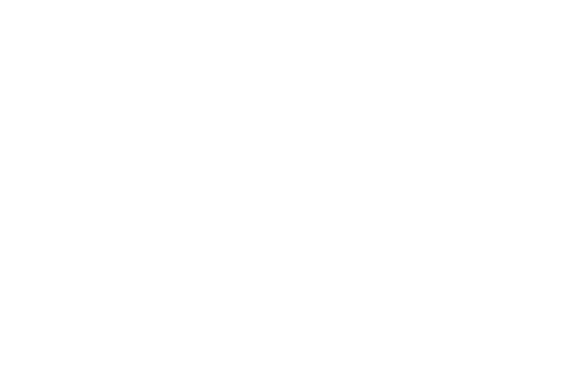

 message:  [8 8 7 0]
 output:  0
 epoch no:  400  avg reward 0.2675
 message:  [4 0 5 0]
 output:  2
 epoch no:  800  avg reward 0.26
 message:  [3 7 5 0]
 output:  2
 epoch no:  1200  avg reward 0.2633333333333333
 message:  [4 7 6 0]
 output:  2
 epoch no:  1600  avg reward 0.2733333333333333
 message:  [4 7 6 0]
 output:  2
 epoch no:  2000  avg reward 0.25833333333333336
 message:  [4 7 6 0]
 output:  2
 epoch no:  2400  avg reward 0.25
 message:  [4 7 6 0]
 output:  2
 epoch no:  2800  avg reward 0.25
 message:  [4 7 6 0]
 output:  2
 epoch no:  3200  avg reward 0.2833333333333333
 message:  [4 7 6 0]
 output:  0
 epoch no:  3600  avg reward 0.27166666666666667
 message:  [7 1 6 8]
 output:  1
 epoch no:  4000  avg reward 0.25666666666666665
 message:  [1 1 3 4]
 output:  2
 epoch no:  4400  avg reward 0.2816666666666667
 message:  [8 0 5 0]
 output:  0
 epoch no:  4800  avg reward 0.305
 message:  [8 0 3 0]
 output:  1
 epoch no:  5200  avg reward 0.30666666666666664
 message:  [

 message:  [4 8 7 9]
 output:  0
 epoch no:  43200  avg reward 0.5516666666666666
 message:  [4 8 5 2]
 output:  0
 epoch no:  43600  avg reward 0.6266666666666667
 message:  [6 7 8 4]
 output:  2
 epoch no:  44000  avg reward 0.5716666666666667
 message:  [4 9 3 9]
 output:  0
 epoch no:  44400  avg reward 0.47333333333333333
 message:  [4 8 3 9]
 output:  0
 epoch no:  44800  avg reward 0.4
 message:  [4 8 3 9]
 output:  3
 epoch no:  45200  avg reward 0.465
 message:  [4 8 3 4]
 output:  2
 epoch no:  45600  avg reward 0.5016666666666667
 message:  [4 8 3 9]
 output:  3
 epoch no:  46000  avg reward 0.5633333333333334
 message:  [4 8 1 9]
 output:  3
 epoch no:  46400  avg reward 0.605
 message:  [4 8 3 4]
 output:  1
 epoch no:  46800  avg reward 0.6883333333333334
 message:  [9 8 8 4]
 output:  2
 epoch no:  47200  avg reward 0.7316666666666667
 message:  [4 8 1 9]
 output:  2
 epoch no:  47600  avg reward 0.8
 message:  [5 8 5 4]
 output:  2
 epoch no:  48000  avg reward 0.778333

 message:  [4 7 4 6]
 output:  0
 epoch no:  86000  avg reward 0.6616666666666666
 message:  [5 7 1 3]
 output:  2
 epoch no:  86400  avg reward 0.6416666666666667
 message:  [1 8 6 9]
 output:  2
 epoch no:  86800  avg reward 0.5733333333333334
 message:  [4 7 1 5]
 output:  2
 epoch no:  87200  avg reward 0.555
 message:  [0 7 4 3]
 output:  2
 epoch no:  87600  avg reward 0.655
 message:  [4 7 4 5]
 output:  3
 epoch no:  88000  avg reward 0.6783333333333333
 message:  [1 8 6 9]
 output:  1
 epoch no:  88400  avg reward 0.6316666666666667
 message:  [1 8 6 9]
 output:  0
 epoch no:  88800  avg reward 0.6083333333333333
 message:  [4 7 4 4]
 output:  2
 epoch no:  89200  avg reward 0.5483333333333333
 message:  [1 8 6 9]
 output:  0
 epoch no:  89600  avg reward 0.58
 message:  [4 7 4 4]
 output:  0
 epoch no:  90000  avg reward 0.5116666666666667
 message:  [4 7 4 4]
 output:  2
 epoch no:  90400  avg reward 0.525
 message:  [1 6 5 9]
 output:  2
 epoch no:  90800  avg reward 0.4933

In [ ]:
%matplotlib notebook
import numpy as np
big_rewards = []
game = Game(n_features, n_clusters, n_samples, n_vocab)

debug = True
data = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(n_epochs):
    
    message_batch = []
    img_batch = []
    for i in range(n_batches):
        message = Speaker.act(states= game_pool[i].speaker_input())  # (scalar between 0 and 4)
        message_batch.append(message)
        img = message_to_image(message)
        img_batch.append(img)
    
    features_batch = get_features(img_batch) 
    
    out_batch = []
    reward_batch = []
    for i in range(n_batches):
        out = Listener.act(states = game_pool[i].listener_input(features_batch[i]))
        out_batch.append(out)
        rew = game_pool[i].reward(out)
        reward_batch.append(rew)
        game_pool[i].reset()
    
    e1 = Speaker.model.observe(reward=reward_batch, terminal=[True]*n_batches)
    e2 = Listener.model.observe(reward=reward_batch, terminal=[True]*n_batches)
    assert e1 == e2
    e = e1
    big_rewards.extend(reward_batch)
    big_rewards = big_rewards[-600:]
    if e%100==0:
        print(" message: ", message)
        print(" output: ", out)
        avg_rew = sum(big_rewards)/len(big_rewards)
        print(" epoch no: ", e, " avg reward", avg_rew)
        if(e!=0):
            data.append(avg_rew)
        ax.clear()
        ax.plot(data)
        fig.canvas.draw()
        
    
    if sum(big_rewards)/len(big_rewards)>.50 and i>1000:
        break



5
[0.79106789 0.16739658 0.26190484]
<class 'list'>
[5 7 5 6]


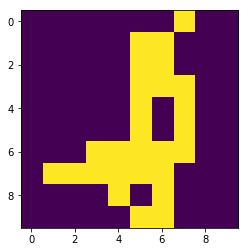

In [106]:
%matplotlib inline
print(5)
i=4
state = X1[Y1==i][np.random.choice(X1[Y1==i].shape[0], 1)][0]
p = state.copy()
print(state)
stokes = []
im = np.zeros((10,10), np.uint8)
print(type(state1))
state = list(state)
state.extend(list(im.flatten()))
m = Speaker.act(states=state)
print(m)
strokes.append(m)
im = message_to_image(strokes)
p = list(p)
p.extend(list(im.flatten()))
m = Speaker.act(states=p)
strokes.append(m)
img = message_to_image(strokes)
plt.imshow(img)

In [120]:
%matplotlib inline
x=[]
y=[]
n_test = 100
from scipy.stats import gaussian_kde
    
for _ in range(n_test):
    for i in range(n_clusters):
        state = X1[Y1==i][np.random.choice(X1[Y1==i].shape[0], 1)][0]
        messages = [] 
        while (len(messages)) < max_len-1:
            message = Speaker.act(states=state)  # (scalar between 0 and 4)
            iterations+=1
            if message == n_vocab - 1:
                if len(messages)==0:
                    obs+=1
                    continue
                else:
                    end_m = True
                    break
            obs+=1
            messages.append(message)
    
        if not end_m:
            act+=1
            message = Speaker.act(states=game.speaker_input())  # (scalar between 0 and 4)
            if message!=(n_vocab-1):
                messages.append(message)
        x.append(i)
        y.append(messages)
    
print(x)
print(y)

KeyboardInterrupt: 

In [110]:
y_distinct = [[0,0], [1, 1], [0,1], [2,0], [2,1],[1,2],[2,2], [1,0], [0,2], [0], [2]]
print("distinct", y_distinct)
y_ind = []
for i in y:
    done = False
    for j in range(len(y_distinct)-1):
        if len(i)<2:
            if i[0]==y_distinct[9][0]:
                y_ind.append(9)
                done=True
                break
            elif i[0] == y_distinct[10][0]:
                y_ind.append(10)
                done=True
                break
        elif i[0]==y_distinct[j][0] and i[1]==y_distinct[j][1]:
            y_ind.append(j)
            done=True
            break
    if not done:
        print(i, "not in disn")
print(y_ind)


# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots()
# plt.scatter(x, y, c=z, s=100, edgecolor='')
# plt.show()
# print(x)
# print(y)

distinct [[0, 0], [1, 1], [0, 1], [2, 0], [2, 1], [1, 2], [2, 2], [1, 0], [0, 2], [0], [2]]
[0, 7, 7, 7, 3, 10, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 4, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 10, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 10, 0, 7, 7, 7, 3, 6, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 0, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 0, 3, 0, 7, 7, 7, 0, 3, 0, 7, 7, 7, 10, 3, 0, 0, 7, 7, 10, 3, 0, 7, 7, 7, 3, 10, 0, 7, 7, 7, 3, 6, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 3, 0, 0, 7, 7, 3, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 8, 3, 0, 7, 7, 7, 10, 3, 0, 7, 7, 7, 3, 10, 0, 0, 7, 7, 3, 3, 0, 7, 7, 7, 0, 10, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 10, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 0, 10, 0, 7, 0, 7, 3, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 0, 3, 0, 7, 7, 7, 3, 10, 0, 7, 0, 7, 0, 10, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 0, 3, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 0, 3, 0, 7, 7, 7, 10, 10, 0, 0, 7, 7, 3, 10, 0, 7, 0, 7, 3, 10, 0, 7, 7, 7, 3, 3, 0, 7, 7, 7, 3, 10, 0, 7, 7, 7, 10, 3, 0, 7, 

In [111]:
matrix = [[0 for _ in range(len(y_distinct))] for _ in range(n_clusters)]
for i, j in zip(x, y_ind):
        matrix[i][j] +=1
print(matrix)
        

[[100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [6, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0], [6, 0, 0, 0, 0, 0, 0, 94, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0], [20, 0, 0, 66, 0, 0, 4, 0, 2, 1, 7], [0, 0, 0, 65, 1, 0, 5, 0, 0, 0, 29]]


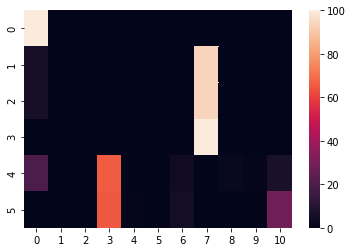

In [112]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
       
df_cm = pd.DataFrame(matrix, range(n_clusters),
                  range(len(y_distinct)))
#plt.figure(figsize = (10,7))
# sn.set(font_scale=1.4)#for label size
plt.figure(1)
sn.heatmap(df_cm)# font size
plt.show()

In [618]:
name = "features-{}_clusters-{}_sample-{}_vocab-{}_accuracy-{}".format(n_features, n_clusters, n_samples, n_vocab, 80)
Speaker.save_model("weights/speaker_"+name)
Listener.save_model("weights/listener_"+name)
print(name)

features-3_clusters-5_sample-3_vocab-5_accuracy-80


In [620]:
import pickle
filename = "log/rewards_"+name
with open(filename, 'wb') as fp:
    pickle.dump(data, fp)

In [555]:
# sanity check

i=4
st = X1[Y1==i][np.random.choice(X1[Y1==i].shape[0], 1)][0]
# st = st
print(st)
mes = Speaker.act(states= st)
print(mes)
i=1
st2 = X1[Y1==i][np.random.choice(X1[Y1==i].shape[0], 1)][0]
st2 = st2

i=0
st3 = X1[Y1==i][np.random.choice(X1[Y1==i].shape[0], 1)][0]
st3 = st3
print(st.shape, st2.shape, st3.shape, mes.shape)
ost = np.concatenate([st, st2, st3, [mes]], axis=0)
out = Listener.act(states=ost)
print(out)

[0.32913374 0.68331159 0.14363785]
0
(3,) (3,) (3,) ()
2


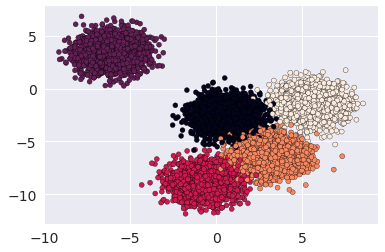

In [682]:
X1, Y1 = make_blobs(n_samples=10000, n_features=2, centers=n_clusters)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

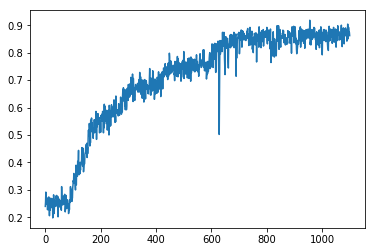

In [103]:
%matplotlib inline
plt.plot(data)

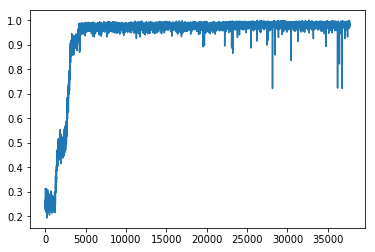

In [ ]:
%matplotlib inline
plt.plot(data)

In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
input = Input(shape=(200,200, 3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)
output_vgg16_conv

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

AttributeError: 'Tensor' object has no attribute 'summary'

In [35]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarn

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 232s 4ms/step - loss: 0.3311 - acc: 0.8980 - val_loss: 0.0707 - val_acc: 0.9773
Epoch 2/3
60000/60000 [==============================] - 240s 4ms/step - loss: 0.1208 - acc: 0.9655 - val_loss: 0.0499 - val_acc: 0.9843
Epoch 3/3
60000/60000 [==============================] - 231s 4ms/step - loss: 0.0941 - acc: 0.9722 - val_loss: 0.0367 - val_acc: 0.9881
Test loss: 0.036734158796447446
Test accuracy: 0.9881


In [53]:
print(model.summary())
layer_name = 'dense_1'
intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(arr[:, : , 0].reshape((1, 28, 28, 1)))
intermediate_output[0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                589888    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

array([342.21643 ,   0.      ,   0.      ,   0.      , 175.94054 ,
         0.      ,   0.      ,   0.      ,   0.      , 181.3873  ,
       398.29657 ,   0.      , 165.07257 ,   0.      ,   0.      ,
         0.      ,  38.648113,   0.      ,  36.168182,   0.      ,
       117.9395  ,   0.      ,   0.      ,  74.16782 ,   0.      ,
        90.33346 ,  95.229034, 351.82516 ,   0.      ,   0.      ,
        13.208629,   0.      , 594.54297 ,   0.      ,   0.      ,
        27.306543,   0.      ,   0.      ,   0.      , 371.4118  ,
         0.      , 204.23553 ,   0.      ,   0.      ,   0.      ,
         0.      ,  18.743675, 494.3986  ,   0.      ,  98.603165,
       318.0518  ,   0.      ,   0.      , 202.63165 , 328.36438 ,
       198.0721  ,   0.      ,   0.      ,   0.      , 196.80656 ,
         0.      ,   0.      ,   0.      ,  20.625679], dtype=float32)

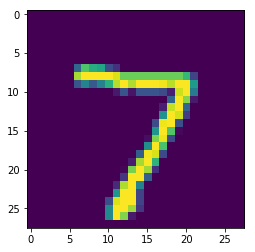

In [45]:
plt.imshow(x_test[0].reshape((28, 28)))

In [39]:
from matplotlib import pyplot as plt
plt.matshow(intermediate_output[0, :, :, 3], cmap='viridis')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [43]:
# print(model.summary())
# [i.name for i in model.layers]

In [78]:
import numpy as np
import cv2
img = np.zeros((28,28), np.uint8)
cv2.line(img,(5, 5),(20, 5),(255,0,0),2)
cv2.line(img,(20, 5),(10, 25),(255,0,0),2)
# cv2.line(img,(4,28),(10, 21),(255,0,0),2)
img = img/255
img = img.reshape(1, 28, 28, 1)
model.predict(img)
# plt.imshow(img)

array([[5.6973254e-12, 8.7739527e-06, 9.0678828e-04, 1.0795338e-03,
        2.9779714e-09, 8.0305686e-11, 9.3289178e-12, 9.9800056e-01,
        3.1652025e-08, 4.2991774e-06]], dtype=float32)

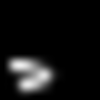

In [79]:
from wand.image import Image
from wand.drawing import Drawing
from wand.color import Color
import numpy as np

draw =  Drawing()
draw.stroke_color = Color('white')
draw.stroke_width = 1
draw.fill_color = Color('black')
points = [(2,8),  # Start point
          (5,7),  # First control
          (5,7),  # Second control
          (1,6)]  # End point
draw.bezier(points)
image =  Image(width=10,
           height=10,
           background=Color('black'))
draw(image)
image.resize(height=100, width=100)
arr = np.array(image)
image

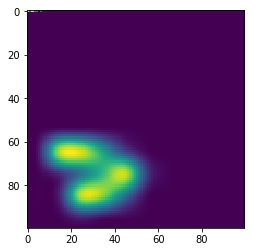

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(arr[:, : , 0])